In [1]:
import numpy as np

from matplotlib import pyplot as plt

from prysm import Seidel, MTF
from prysm.otf import diffraction_limited_mtf
%matplotlib inline
plt.style.use('ggplot')

To generate the code V data:

1.  Create a new lens
2.  Set it to f/2
3.  Set it to 560nm as the only wavelength
4.  run "C:\CODEV111\macro\aberrationgenerator.seq" 0 0 1 0 0 0 0 ;GO
5.  Code V> MTF;GEO NO;MFR 950;IFR 10;NRD 512;CHT FRE y;GO

In [2]:
# Data computed by Code V's aberration generator macro
codev = '''
    0 .999   .999        .999
   10 .986   .986        .966
   20 .971   .971        .900
   30 .957   .957        .815
   40 .943   .943        .722
   50 .929   .929        .630
   60 .915   .914        .545
   70 .900   .900        .470
   80 .886   .886        .406
   90 .872   .872        .353
  100 .858   .858        .309
  110 .844   .843        .274
  120 .829   .829        .245
  130 .815   .815        .223
  140 .801   .801        .204
  150 .787   .787        .189
  160 .773   .773        .177
  170 .759   .759        .166
  180 .745   .745        .157
  190 .731   .731        .149
  200 .717   .717        .141
  210 .703   .703        .134
  220 .689   .689        .127
  230 .676   .676        .120
  240 .662   .662        .114
  250 .648   .648        .108
  260 .635   .634        .102
  270 .621   .621        .096
  280 .607   .607        .090
  290 .594   .594        .084
  300 .580   .580        .078
  310 .567   .567        .073
  320 .554   .554        .067
  330 .540   .540        .062
  340 .527   .527        .057
  350 .514   .514        .052
  360 .501   .501        .047
  370 .488   .488        .042
  380 .475   .475        .038
  390 .462   .462        .033
  400 .449   .449        .030
  410 .437   .437        .026
  420 .424   .424        .022
  430 .411   .411        .019
  440 .399   .399        .016
  450 .387   .387        .014
  460 .374   .374        .011
  470 .362   .362        .009
  480 .350   .350        .007
  490 .338   .338        .005
  500 .326   .326        .004
  510 .314   .314        .002
  520 .303   .303        .001
  530 .291   .291        .000
  540 .280   .280        .001
  550 .269   .269        .002
  560 .257   .257        .003
  570 .246   .246        .003
  580 .235   .235        .004
  590 .225   .225        .005
  600 .214   .214        .005
  610 .204   .203        .006
  620 .193   .193        .006
  630 .183   .183        .007
  640 .173   .173        .007
  650 .163   .163        .008
  660 .153   .153        .008
  670 .144   .144        .009
  680 .135   .135        .009
  690 .125   .125        .010
  700 .117   .116        .010
  710 .108   .108        .010
  720 .099   .099        .010
  730 .091   .091        .010
  740 .083   .083        .009
  750 .075   .075        .009
  760 .067   .067        .007
  770 .060   .060        .006
  780 .053   .053        .004
  790 .046   .046        .002
  800 .040   .040        .000
  810 .033   .033        .002
  820 .028   .028        .004
  830 .022   .022        .006
  840 .017   .017        .007
  850 .013   .013        .007
  860 .008   .008        .006
  870 .005   .005        .004
  880 .002   .002        .002
  890 .000   .000        .000
  900 .000   .000        .000
  910 .000   .000        .000
  920 .000   .000        .000
  930 .000   .000        .000
  940 .000   .000        .000
  950 .000   .000        .000
'''
codev = np.fromstring(codev, dtype=float, sep=' ').reshape((96,4))
freqs, diffraction, sys = codev[:,0], codev[:,1], codev[:,3]

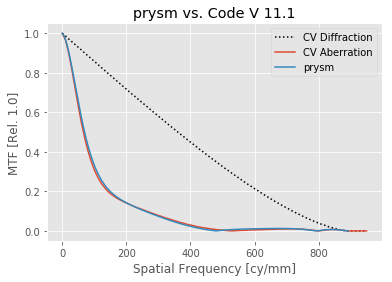

In [3]:
# data computed by prysm
pupil = Seidel(W040=1, wavelength=0.560, samples=512, epd=5.0)
mtf = MTF.from_pupil(pupil, efl=10.0)
unit, tan = mtf.tan

# plot prysm and Code V for a superficial comparison
fig, ax = plt.subplots()
ax.plot(freqs, diffraction, c='k', ls=':', label='CV Diffraction')
ax.plot(freqs, sys, label='CV Aberration')
ax.plot(unit, tan, label='prysm')
ax.legend()
ax.set(xlabel='Spatial Frequency [cy/mm]', ylabel='MTF [Rel. 1.0]', title='prysm vs. Code V 11.1');
#plt.savefig('prysm_vs_codev_1wv_sph.png', dpi=200, bbox_inches='tight')

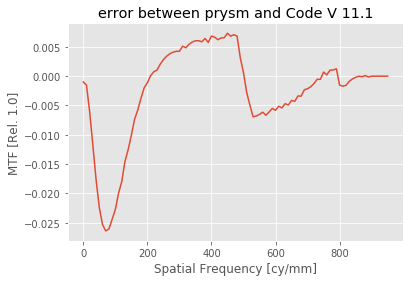

In [4]:
# now interpolate prysm onto Code V's grid and compare the two
from scipy.interpolate import interp1d
prysm_interpf = interp1d(unit, tan, kind='linear', fill_value=0, bounds_error=False)
prysm_on_codev_pts = prysm_interpf(freqs)

diff = sys - prysm_on_codev_pts
fig, ax = plt.subplots()
ax.plot(freqs,diff)
ax.set(xlabel='Spatial Frequency [cy/mm]', ylabel='MTF [Rel. 1.0]', title='error between prysm and Code V 11.1');
#plt.savefig('prysm_vs_codev_err_1wv_sph.png', dpi=200, bbox_inches='tight')

The error appears to be one in the amount of spherical aberration present.  This is likely due to the imprecision of prysm's puil masking (pupils are slightly smaller than specified due to the nature of the masking algorithm used).  There is good agreement with prysm using 1.05 waves of spherical aberration:

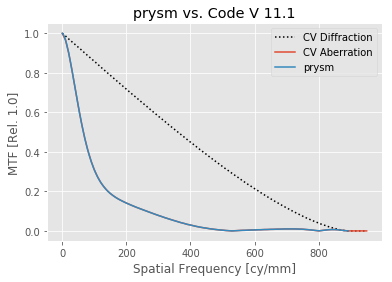

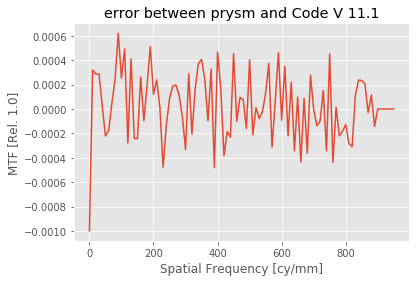

In [5]:
# perform the comparison again with 1.05wv spherical from prysm
pupil = Seidel(W040=1.05, wavelength=0.560, samples=512, epd=5.0)
mtf = MTF.from_pupil(pupil, efl=10.0)
unit, tan = mtf.tan

fig, ax = plt.subplots()
ax.plot(freqs, diffraction, c='k', ls=':', label='CV Diffraction')
ax.plot(freqs, sys, label='CV Aberration')
ax.plot(unit, tan, label='prysm')
ax.legend()
ax.set(xlabel='Spatial Frequency [cy/mm]', ylabel='MTF [Rel. 1.0]', title='prysm vs. Code V 11.1')

prysm_interpf = interp1d(unit, tan, kind='linear', fill_value=0, bounds_error=False)
prysm_on_codev_pts = prysm_interpf(freqs)

diff = sys - prysm_on_codev_pts
fig, ax = plt.subplots()
plt.plot(freqs,diff)
ax.set(xlabel='Spatial Frequency [cy/mm]', ylabel='MTF [Rel. 1.0]', title='error between prysm and Code V 11.1');

The fit was very good, and now matches to less than .1% MTF.